<a href="https://colab.research.google.com/github/KevinSikorskiBase2S/machine-learning-intro-workshop/blob/master/LatentMike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Save a Copy (File -> Save a copy in Drive) to run

# Finding yourself in the latent space of StyleGAN

Dmitry Nikitko (puzer) wrote [the original code](https://github.com/Puzer/stylegan) for this notebook which extends the work released by NVidia on StyleGAN. I have modified and annotated it to make it easier to use in Colab. After running through this notebook you should have a StyleGAN generated image (or set of images) which closely match photos of you that you've uploaded.

You'll also have a `npy` file which is the latent code (or location) of your image in the StyleGAN latent space.

In [1]:
!git clone https://github.com/Puzer/stylegan

Cloning into 'stylegan'...
remote: Enumerating objects: 105, done.
remote: Total 105 (delta 0), reused 0 (delta 0), pack-reused 105
Receiving objects: 100% (105/105), 10.39 MiB | 15.15 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [2]:
%cd stylegan
# Use the version this notebook was built with
!git checkout c3fb250c65840c8837ded78e34485227755c2473

/content/stylegan
Note: checking out 'c3fb250c65840c8837ded78e34485227755c2473'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at c3fb250 Update README.md


In [0]:
!mkdir raw_images aligned_images generated_images latent_representations

## Add your image(s)

Upload your image using the Sidebar now. 

To open the sidebar select "View" and then "Table of Contents".

The sidebar should now be open. Click the "Files" tab.

Before uploading make sure:

1.   The image(s) you're using can be opened by PIL (jpg, png, etc)
2.   The images are larger than 1024x1024. Preferably significantly larger so the aligner can crop out a high resolution section of the image containing your face.
3.   Your face in the image is well lit and facing the camera (for best results)

Click ''Upload" in the sidebar and select the images you want to upload from your computer.

Note: All files uploaded in this manner end up in the root of the file tree. We'll move them into the correct spot next.

**OR** just download some canned images and we can use them.  Bob Ross, Lionel Richie, and Mike Haldeman have been graciously volunteered.

In [0]:
!git clone https://github.com/KevinSikorskiBase2S/machine-learning-intro-workshop
!cp machine-learning-intro-workshop/images/isItMeYourLookingFor/*.jpg raw_images

In [0]:
# e.g. mv ../me.jpg raw_images/
!mv ../Bob.jpg raw_images/
!mv ../Mike.jpg raw_images/
!mv ../lionel.jpg raw_images/

## Align your images

In [5]:
!python align_images.py raw_images aligned_images

Using TensorFlow backend.
64045056/64040097 [==============================] - 3s 0us/step


This should produce an image in `aligned_images/` for every image in `raw_images/`.

It's a good idea to check that this process worked by using the Files browser to download each aligned image and make sure it looks reasonable. If you encounter scrambled images it might be because your original raw images are too small.

## Search for your latent self

The script `encode_images.py` will minimize the perceptual loss between generated images from StyleGAN and each of the images you've uploaded. (By default this happens one at a time)

I've had good results at 1000 iterations and it's best to check the general quality before coming back and ramping up the number of iterations to produce a high-quality latent.

Higher quality comes at a cost of course. 10000 iterations will take about **one hour** for one image.

**NOTE:** You may get a warning about the GPU memory limit when running this script. Don't worry it will still complete.

In [6]:
!python encode_images.py aligned_images/ generated_images/ latent_representations/ --iterations 1000




Using TensorFlow backend.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

58892288/58889256 [==============================] - 2s 0us/step


  0% 0/3 [00:00<?, ?it/s]
  0% 0/1000 [00:00<?, ?it/s]WARNING:tensorflow:From /content/stylegan/encoder/perceptual_model.py:73: The name tf.train.GradientDescentOptimizer is deprecated. Please use tf.compat.v1.train.GradientDescentOptimizer instead.


lionel_01 Loss: 2.97:   0% 0/1000 [00:06<?, ?it/s]
lionel_01 Loss: 2.97:   0% 1/1000 [00:06<1:41:49,  6.12s/it]
lionel_01 Loss: 1.82:   0% 1/1000 [00:06<1:41:49,  6.12s/it]
lionel_01 Loss: 1.82:   0% 2/1000 [00:06<1:13:02,  4.39s/it]
lionel_01 Loss: 1.73:   0% 2/1000 [00:06<1:13:02,  4.39s/it]
lionel_01 Loss: 1.73:   0% 3/1000 [00:06<52:54,  3.18s/it]  
lionel_01 Loss: 1.70:   0% 3/1000 [00:07<52:54,  3.18s/it]
lionel_01 Loss: 1.70:   0% 4/1000 [00:07<38:46,  2.34s/it]
lionel_01 Loss: 1.68:   0% 4/1000 [00:07<38:46,  2.34s/it]
lionel_01 Loss: 1.68: 

## Download Your Results

After the above cell has finished writing there should be an image in `generated_images/` for each image in `aligned_images/`.

You can right-click and download each of these images to see your final latent self.

### Latent Representation

You can also download the `npy` files in the `latent_representations/` directory. Each of those is a serialized numpy array which contains the (18, 512) array encoding the point in latent space which corresponds to the generated image. Which you can open with `latent = np.load('filename.npy')`

### Change your Smile, Gender, or Age

Once your latent representation has been generated and saved you can explore the volume around it through latent vectors. Puzer has provided vectors for Smile, Gender and Age so you can see what you look like as your latent self varies along those axes.

Run the following cells.

In [7]:
import os
import pickle
import PIL.Image
import numpy as np
import dnnlib
import dnnlib.tflib as tflib
import config
from encoder.generator_model import Generator

import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
URL_FFHQ = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ'

tflib.init_tf()
with dnnlib.util.open_url(URL_FFHQ, cache_dir=config.cache_dir) as f:
    generator_network, discriminator_network, Gs_network = pickle.load(f)

generator = Generator(Gs_network, batch_size=1, randomize_noise=False)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
def generate_image(latent_vector):
    latent_vector = latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(latent_vector)
    img_array = generator.generate_images()[0]
    img = PIL.Image.fromarray(img_array, 'RGB')
    return img.resize((256, 256))

def move_and_show(latent_vector, direction, coeffs):
    fig,ax = plt.subplots(1, len(coeffs), figsize=(15, 10), dpi=80)
    for i, coeff in enumerate(coeffs):
        new_latent_vector = latent_vector.copy()
        new_latent_vector[:8] = (latent_vector + coeff*direction)[:8]
        ax[i].imshow(generate_image(new_latent_vector))
        ax[i].set_title('Coeff: %0.1f' % coeff)
    [x.axis('off') for x in ax]
    plt.show()

In [0]:
# Loading already learned representations
lionelRep = np.load('latent_representations/lionel_01.npy')
mikeRep = np.load('latent_representations/Mike_01.npy')
bobRep = np.load('latent_representations/Bob_01.npy')

In [0]:
# Loading already learned latent directions
smile_direction = np.load('ffhq_dataset/latent_directions/smile.npy')
gender_direction = np.load('ffhq_dataset/latent_directions/gender.npy')
age_direction = np.load('ffhq_dataset/latent_directions/age.npy')

# In general it's possible to find directions of almost any face attributes: position, hair style or color ... 
# Additional scripts for doing so will be realised soon

# Smile transformation

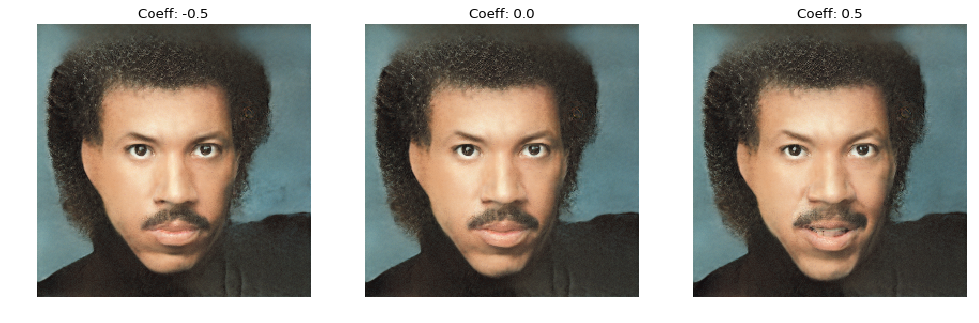

In [12]:
move_and_show(lionelRep, smile_direction, [-0.5, 0, 0.5])

# Gender transformation

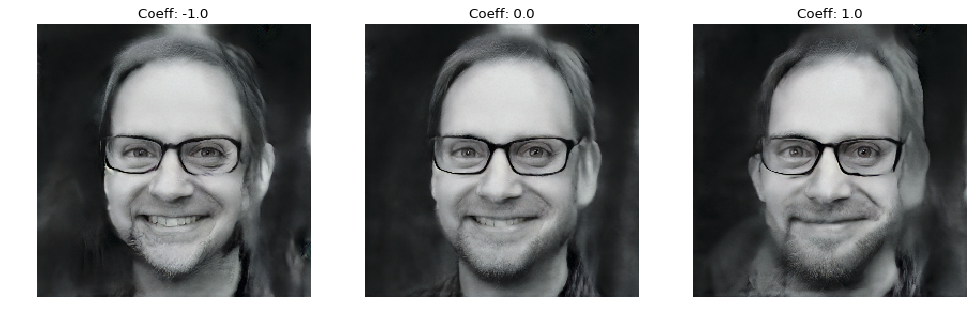

In [13]:
move_and_show(mikeRep, gender_direction, [-1, 0, 1])

# Age transformation

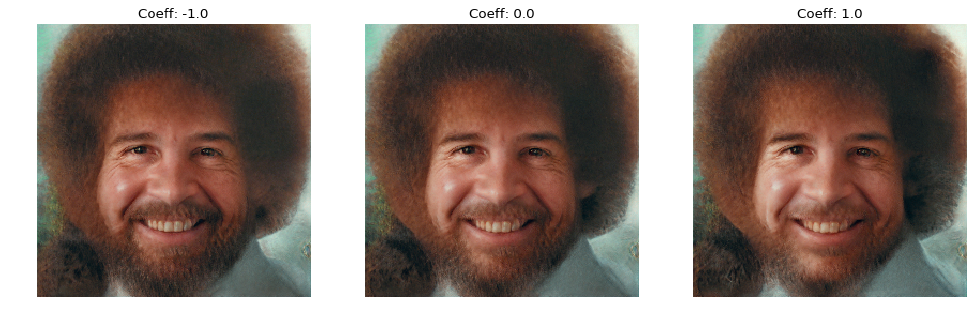

In [14]:
move_and_show(bobRep, age_direction, [-1, 0, 1])

blah


In [0]:
duration_sec = 15.0
smoothing_sec = 1.0
mp4_fps = 20
num_frames = int(np.rint(duration_sec * mp4_fps))

In [0]:
def generate_image_for_video(latent_vector):
    latent_vector = latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(latent_vector)
    img_array = generator.generate_images()[0]

    return img_array
  
  
def move_for_video(latent_vector, direction, coeff):
  
  new_latent_vector = latent_vector.copy()
  new_latent_vector[:8] = (latent_vector + coeff*direction)[:8]
  
  img_array = generate_image(new_latent_vector)
  
  return img_array

We need a directory to collect our output in.

In [0]:
!mkdir results

In [0]:
# If you're interpolating between two characters, set these characters here
char1 = lionelRep
char2 = mikeRep
char3 = bobRep

def get_latent_mix(alpha):
  coeff = (alpha%100)*0.01
  seg=int(alpha/100)
#  print (seg)
  if (seg==0):
    leftChar=char1
    rightChar=char2
  if (seg==1):
    leftChar=char2
    rightChar=char3
  if (seg==2):
    leftChar=char3
    rightChar=char2
  return (1-coeff)*leftChar + coeff*rightChar


A simple test...

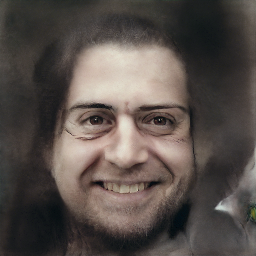

In [50]:
generate_image(get_latent_mix(255))

In [51]:

# This creates an nd array that stores all the image frames fot cross-character interpolation
src_images = np.stack(generate_image_for_video(get_latent_mix(alpha)) for alpha in range (300))
#src_images = np.stack(generate_image_for_video((0.01*alpha*char2)+((1-(0.01*alpha))*char1)) for alpha in range (300))


# Uncomment the next line if you want to do a character transforation video, and choose the arguments as per your requirement
#src_images = np.stack(move_for_video(dany_meme, smile_direction, (0.02*alpha)) for alpha in range (-100,100))


def make_frame(t):
    frame_idx = int(np.clip(np.round(t * mp4_fps), 0, num_frames - 1))
    src_image = src_images[frame_idx]
    return np.array(src_image)

# Generate video.
import moviepy.editor
mp4_file = 'results/interpolate.mp4'
mp4_codec = 'libx264'
mp4_bitrate = '5M'

video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)
video_clip.write_videofile(mp4_file, fps=mp4_fps, codec=mp4_codec, bitrate=mp4_bitrate)

[MoviePy] >>>> Building video results/interpolate.mp4
[MoviePy] Writing video results/interpolate.mp4


100%|█████████▉| 300/301 [00:27<00:00,  9.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: results/interpolate.mp4 

